In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config.config import LSTM_DATA_DIR, OBSERVACIONS_FILTRAT_DIR, LSTM_PREDICTIONS_DIR, OBSERVACIONS_DIR, AUTOENCODER_DIR, UNGAUGED_DIR
import pandas as pd
import os
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
from keras import regularizers
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import joblib
from src.LSTM import flatten, scale_data_anomaly_detection
from keras.models import load_model
from src.LSTM import LSTM
from src.utils import parse_station


In [3]:
#get all the files in the directory
files = os.listdir(LSTM_PREDICTIONS_DIR)
ungauged_files = os.listdir(UNGAUGED_DIR)


In [4]:
data_all_stations = []
data_all_stations_test = []
data_all_stations_anomaly = []
data_all_stations_test_anomaly = []
normalization_features = []
input_length = 14

#read all the files that are csv
for file in files:
    if file.endswith(".csv"):

        lstm_fitted = parse_station(file.replace('.csv', '_stats.csv'), only_testing = True)
        nash = lstm_fitted.nash()

        if nash > 0.2:

            print(nash)

            df = pd.read_csv(os.path.join(LSTM_PREDICTIONS_DIR / file))

            df['ds'] = pd.to_datetime(df['ds'])

            #marquem com a anomalia els valors que son nans al fitxer observacions_filtrat pero no al fitxer observacions original
            df_observacions_originals = pd.read_csv(os.path.join(OBSERVACIONS_DIR / file), parse_dates = ['Date'])
            df_observacions_filtrades = pd.read_csv(os.path.join(OBSERVACIONS_FILTRAT_DIR / file), parse_dates = ['Date'])

            df_observacions_originals.rename(columns = {'Date': 'ds', 'Flow': 'y_original'}, inplace = True)
            df_observacions_filtrades.rename(columns = {'Date': 'ds', 'Flow': 'y_original_filtrades'}, inplace = True)

            df = df.merge(df_observacions_originals, on = 'ds', how = 'left')
            df = df.merge(df_observacions_filtrades, on = 'ds', how = 'left')


            #add column is anomaly, if y_original is not na and y_original_filtrades is na, then is anomaly
            #df['is_anomaly'] = df['y_original'].notna() & df['y_original_filtrades'].isna()
            df['is_anomaly'] = df['y_original_filtrades'].isna()    #train autoencoder without anomaly or empty data

            #Afegim els 150 de la finestra de look-back (traiem l'últim 15% tenint en compte la serie sencera)
            n = len(df) + 150 

            df_train = df[:int(n*0.85)]
            df_test = df[int(n*0.85):]


            #duplicate last row with concat
            df_train = pd.concat([df_train, df_train.iloc[[-1]]])
            df_test = pd.concat([df_test, df_test.iloc[[-1]]])

            #move is_anomaly values to next row. That way, generator will return [(sliding window of 14 values, is_anomaly of 14th value))]
            df_train['is_anomaly'] = df_train['is_anomaly'].shift(+1)
            df_test['is_anomaly'] = df_test['is_anomaly'].shift(+1)

            generator = TimeseriesGenerator(df_train[['y', 'yhat']].values, df_train['is_anomaly'].values, length=14, batch_size=1)
            test_generator = TimeseriesGenerator(df_test[['y', 'yhat']].values, df_test['is_anomaly'].values, length=14, batch_size=1)


            merged_generator = np.array([sample[0][0] for sample in generator if not sample[1][0]])
            merged_generator_test = np.array([sample[0][0] for sample in test_generator if not sample[1][0]])

            merged_generator_anomaly = np.array([sample[0][0] for sample in generator if sample[1][0] and not np.isnan(sample[0][0][-1][0])])
            merged_generator_test_anomaly = np.array([sample[0][0] for sample in test_generator if sample[1][0] and not np.isnan(sample[0][0][-1][0])])


            data_all_stations.extend(merged_generator)
            data_all_stations_test.extend(merged_generator_test)

            data_all_stations_anomaly.extend(merged_generator_anomaly)
            data_all_stations_test_anomaly.extend(merged_generator_test_anomaly)

30/30 [==============================] - 0s 6ms/step
0.2226713530528429
30/30 [==============================] - 0s 7ms/step
0.21289693739516902
30/30 [==============================] - 0s 7ms/step
0.32709936712823073
30/30 [==============================] - 0s 6ms/step
0.31185743627751294
30/30 [==============================] - 0s 7ms/step
0.2729130042816642
30/30 [==============================] - 0s 7ms/step
0.2625266647307024
30/30 [==============================] - 0s 6ms/step
0.21674448885347253
30/30 [==============================] - 0s 8ms/step
0.2977301556588704
30/30 [==============================] - 0s 6ms/step
0.39996853081903627
30/30 [==============================] - 0s 6ms/step
0.45428526017513327
30/30 [==============================] - 0s 7ms/step
0.2081903731298853
30/30 [==============================] - 0s 7ms/step
0.5338191217929905
30/30 [==============================] - 0s 6ms/step


In [6]:
"""
#read all the files that are csv
for station in ungauged_files:

    observations = pd.read_csv(OBSERVACIONS_DIR / station, index_col = 0, parse_dates = True)
    stats = pd.read_csv(UNGAUGED_DIR / station, parse_dates = True)
    stats.rename(columns = {'datetime': 'ds'}, inplace = True)

    #Replace valid observations for all observations
    stats['y'] = observations['Flow'].astype('float32').values
    stats.drop(columns = ['Flow'], inplace = True)
    lstm_model = LSTM(station_name = station, model_with_flow=False, transfer_learning=False)
    lstm_fitted = lstm_model.fit(stats)
    df = lstm_fitted.get_df()

    df['is_anomaly'] = True

    #duplicate last row with concat
    df_train = pd.concat([df, df.iloc[[-1]]])
    
    #move is_anomaly values to next row. That way, generator will return [(sliding window of 14 values, is_anomaly of 14th value))]
    df_train['is_anomaly'] = df_train['is_anomaly'].shift(+1)

    generator = TimeseriesGenerator(df_train[['y', 'yhat']].values, df_train['is_anomaly'].values, length=14, batch_size=1)
    merged_generator_test_anomaly = np.array([sample[0][0] for sample in generator if not sample[1][0]])
    data_all_stations_test_anomaly.extend(merged_generator_test_anomaly)
"""


"\n#read all the files that are csv\nfor station in ungauged_files:\n\n    observations = pd.read_csv(OBSERVACIONS_DIR / station, index_col = 0, parse_dates = True)\n    stats = pd.read_csv(UNGAUGED_DIR / station, parse_dates = True)\n    stats.rename(columns = {'datetime': 'ds'}, inplace = True)\n\n    #Replace valid observations for all observations\n    stats['y'] = observations['Flow'].astype('float32').values\n    stats.drop(columns = ['Flow'], inplace = True)\n    lstm_model = LSTM(station_name = station, model_with_flow=False, transfer_learning=False)\n    lstm_fitted = lstm_model.fit(stats)\n    df = lstm_fitted.get_df()\n\n    df['is_anomaly'] = True\n\n    #duplicate last row with concat\n    df_train = pd.concat([df, df.iloc[[-1]]])\n    \n    #move is_anomaly values to next row. That way, generator will return [(sliding window of 14 values, is_anomaly of 14th value))]\n    df_train['is_anomaly'] = df_train['is_anomaly'].shift(+1)\n\n    generator = TimeseriesGenerator(df_tr

In [7]:
X_train = scale_data_anomaly_detection(data_all_stations)
X_test = scale_data_anomaly_detection(data_all_stations_test)
X_train_anomaly = scale_data_anomaly_detection(data_all_stations_anomaly)
X_test_anomaly = scale_data_anomaly_detection(data_all_stations_test_anomaly)

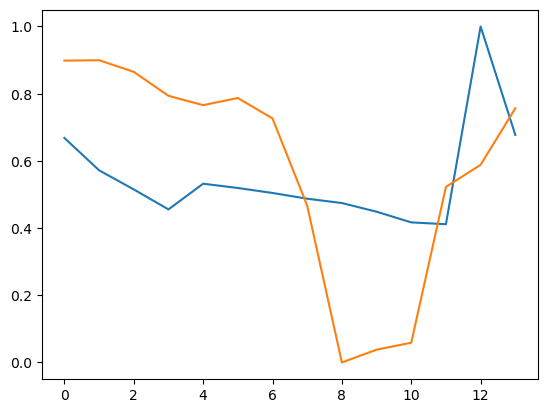

In [30]:
a = X_train[642]
#unzip list of lists
b, c = zip(*a)
c = list(c)
b = list(b)

#plot timeseries in same axis
plt.plot(c)
plt.plot(b)
plt.show()

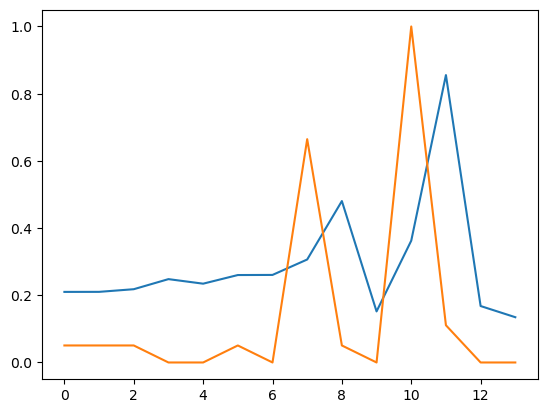

In [31]:
a = X_train[7500]
#unzip list of lists
b, c = zip(*a)
c = list(c)
b = list(b)

#plot timeseries in same axis
plt.plot(c)
plt.plot(b)
plt.show()

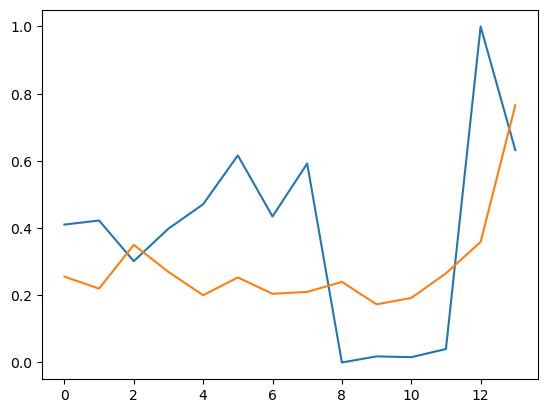

In [27]:
a = X_train_anomaly[350]
#unzip list of lists
b, c = zip(*a)
b = list(b)
c = list(c)

#plot timeseries in same axis
plt.plot(b)
plt.plot(c)
plt.show()

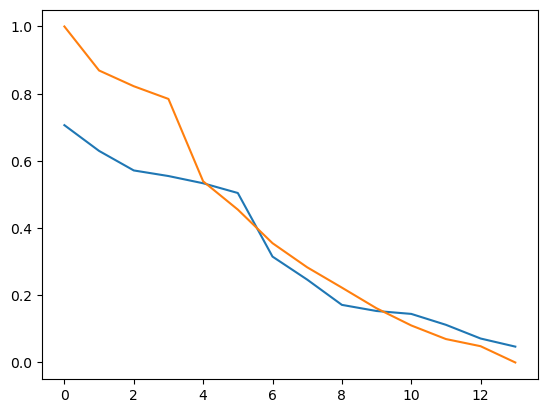

In [32]:
a = X_train_anomaly[700]
#unzip list of lists
b, c = zip(*a)
c = list(c)
b = list(b)

#plot timeseries in same axis
plt.plot(c)
plt.plot(b)
plt.show()